# Analysis of an open dataset with RDataFrame
<hr style="border-top-width: 4px; border-top-color: #34609b;">
This ROOTbook produces a plot of the dimuon invariant mass spectrum starting from a subset of the CMS collision events of Run2010B. 
Every entry in the dataset represents a muon pair. The columns available and their types are:

| Column Name   | Type     | Quantity                                      |
| :-----------: |:--------:| :--------------------------------------------:|
| *E1*          | double   | Energy of the first muon |
| *eta1*        | double   | Pseudorapidity of the first muon |
| *phi1*        | double   | Phi of the first muon |
| *px1*         | double   | X component of the momentum of the first muon |
| *py1*         | double   | Y component of the momentum of the first muon |
| *pz1*         | double   | Z component of the momentum of the first muon |
| *pt1*         | double   | Transverse momentum of the first muon |
| *C1*          | Long64_t | Charge of the momentum of the first muon |
| *E2*          | double   | Energy of the second muon |
| *eta2*        | double   | Pseudorapidity of the second muon |
| *phi2*        | double   | Phi of the second muon |
| *px2*         | double   | X component of the momentum of the second muon |
| *py2*         | double   | Y component of the momentum of the second muon |
| *pz2*         | double   | Z component of the momentum of the second muon |
| *pt2*         | double   | Transverse momentum of the second muon |
| *C2*          | Long64_t | Charge of the momentum of the second muon |



Dataset Reference:<br>
McCauley, T. (2014). Dimuon event information derived from the Run2010B public Mu dataset. CERN Open Data Portal. DOI: [10.7483/OPENDATA.CMS.CB8H.MFFA](http://opendata.cern.ch/record/700).

## Objective of this exercise
The objective is to illustrate how to use RDataFrame to produce the plot of the dimuon invariant mass spectrum, apply some cuts and inspect their efficiency and create some control plots.
In some sense, this is a minimal form of what could be conceptually called an "analysis".

### RDataFrame creation
Let's create an *RDataFrame*, which is located in the *ROOT* namespace. The filename(s) can be specified as a string (with a path or a glob) or a list of strings.
The file path is **https://root.cern/files/teaching/CMS_Open_Dataset.root** and it contains a tree called **data**.

In [1]:
import PyRDF, ROOT
fileName = "https://root.cern/files/teaching/CMS_Open_Dataset.root"
df = PyRDF.RDataFrame("data", fileName)

Welcome to JupyROOT 6.15/01


## Definition of the "analisys" cuts
We need to apply some quality cuts to our muons:
- Central muons, with a pseudorapidity smaller than 2.3
- Muons of opposite charge :)
- Muons with transverse momentum greater than 2 GeV

In addition, we will define the cuts as strings. Remember that the strings need to be valid **C++**!

The dataframe needs to be saved in a variable: we'll need that later. The filters have a name: this will be used at the end of the "analysis" to study the efficiency of the selections.

In [2]:
chargeCutStr = "C1 !=C2"
etaCutStr = "fabs(eta1) < 2.3 && fabs(eta2) < 2.3"
ptCutStr = "pt1 > 2 && pt2 > 2"
df_f = df.Filter(chargeCutStr, "Opposite Charge")\
         .Filter(etaCutStr, "Central Muons")\
         .Filter(ptCutStr, "Sane Pt")

### Creation of the histograms and cutflow efficiency reports
We now create our histograms. We'll prepare some control plots and the invariant mass plot.
The control plots needed are:
- A histogram of the transverse momenta of the muons (1 histogram for each of the leptons) before all cuts
- A 2D histogram with the phi of the first muon on the x axis and the phi of the second muon on the y axis

This is perhaps an opportunity to try out the automatic colouring.

In addition, after drawing, you will invoke the **Report()** method on the top level node to inspect the efficiency of the cuts.

**BE CAREFUL!!** When using notebooks, it's good practice to create **TCanvas** instances explicitly - to display the images you *need* to **Draw** the canvases too (there is no asynchronicity in a notebook: drawing must be explicit).

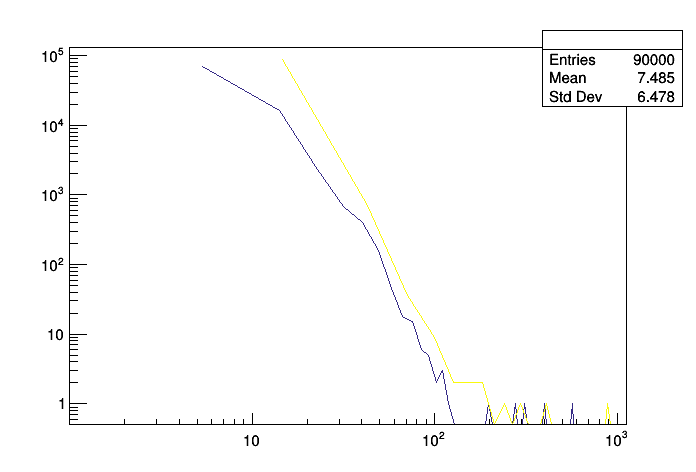

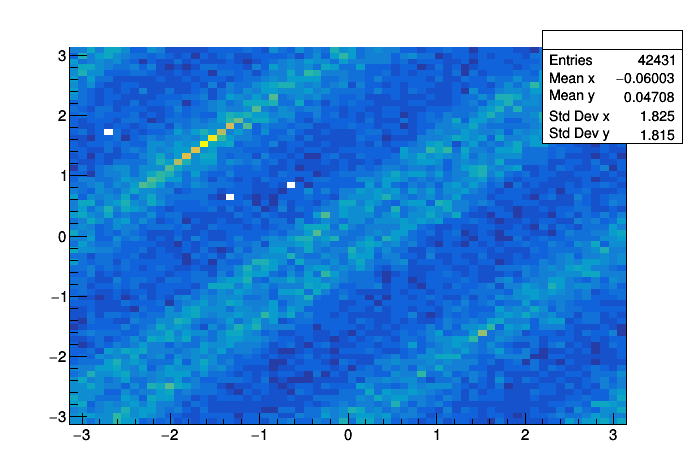

In [3]:
pt1_h = df.Histo1D("pt1")
pt2_h = df.Histo1D("pt2")

muonsPts = ROOT.TCanvas()
pt1_h.Draw("PL PLC PMC")
pt2_h.Draw("Same PL PLC PMC")
muonsPts.SetLogy()
muonsPts.SetLogx()
muonsPts.Draw()

pi = ROOT.TMath.Pi()
phis_h = df_f.Histo2D(("", "", 64, -pi, pi, 64, -pi, pi), "phi1", "phi2")
phis = ROOT.TCanvas()
phis_h.Draw("col")
phis.Draw()

Now we print the efficiency of the cuts

In [4]:
rep = df.Report()
rep.Print()

Opposite Charge: pass=57688      all=90000      --   64.098 %
Central Muons: pass=53303      all=57688      --   92.399 %
Sane Pt   : pass=42431      all=53303      --   79.603 %


## Choosing your backend
The right way to choose a backend in `PyRDF` is `PyRDF.use('myBackendName')`. `PyRDF.use` also additionally accepts a configuration dictionary, which you can use to pass in configuration parameters for your backend. Here are some examples :-

* `PyRDF.use('spark')`
* `PyRDF.use('spark', {'npartitions':5})`

Note that if you don't choose a backend using `PyRDF.use`, the default backend choice would be 'local'.

In [5]:
PyRDF.use('spark', {'npartitions':3})

### Creation of a column holding the invariant mass of the dimuon system
Here we create a new column, which does not exist in the original dataset. 
We can create it with the usual invariant mass formula, packed in a string.
\begin{align}
m = \sqrt{(E1+E2)^2 - (px1+px2)^2 - (py1+py2)^2 - (pz1+pz2)^2 }
\end{align}
Remember that the string needs to be valid **C++**!

The main plot with the invariant mass of the dimuon system has 512 bins from 5 to 110 GeV.

In [6]:
invMassFormulaStr = "sqrt(pow(E1+E2, 2) - (pow(px1+px2, 2) + pow(py1+py2, 2) + pow(pz1+pz2, 2)))"
df_fd = df_f.Define("invMass", invMassFormulaStr)

# Notice the elegance of the initialiser list concept as it is supported by PyROOT
invMass_h = df_fd.Histo1D(("invMass","CMS Opendata;#mu#mu mass [GeV];Events",512,5,110),"invMass")

The final plot with a little extra: interactive ROOT JavaScript visualisation. Feel free to zoom and modify the plot using your mouse and keyboard.

In [7]:
%jsroot on
invMass = ROOT.TCanvas()
invMass_h.Draw()
invMass.SetLogy()
invMass.SetLogx()
invMass.SetGrid()
invMass.Draw()

What resonances do you recognise?